In [10]:
import sys
import os
from pathlib import Path

# Add project root to Python path to enable simcore imports
# The notebook is in simcore/examples/, so go up 2 levels to reach project root
project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from simcore.components.resistor import Resistor
from simcore.components.capacitor import Capacitor
from simcore.components.battery_lut import LithiumBatteryLUT
from simcore.components.constant_power_load import ConstantPowerLoad
from simcore.components.base import EvalContext

from simcore.network.graph import Node, NetworkGraph
from simcore.network.network import Network
from simcore.solver.integrate import run_sim


# ---- Profilo di potenza: 50W + impulso 300W ogni 5s per 0.5s ----
def P_profile(t):
    base = 70.0
    if (t % 5.0) < 0.5:
        return 500.0
    return base


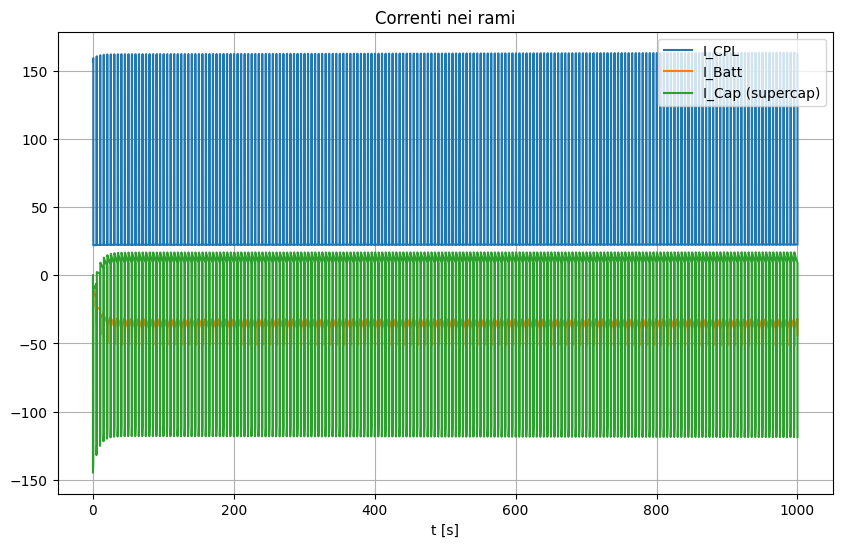

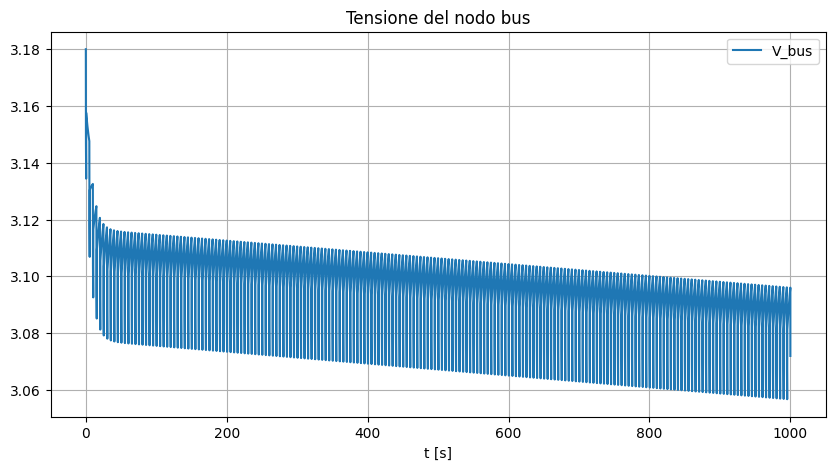

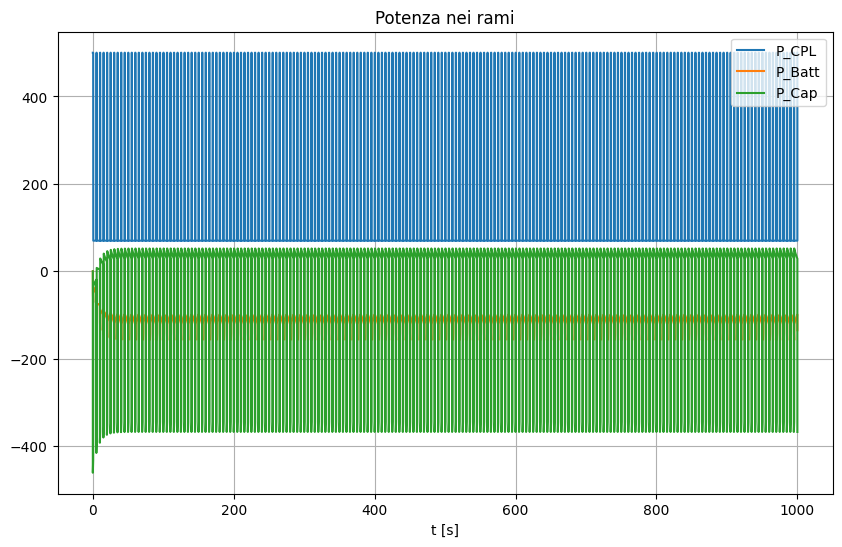

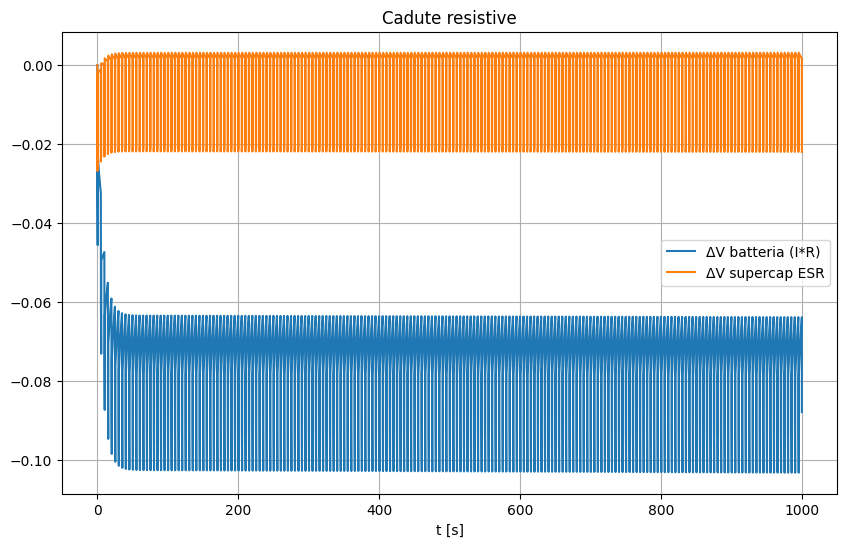

In [36]:
from simcore.components.base import BranchComponent

esr_batt = 0.002
esr_sc = 0.000185 
capacitor_value = 3400.0
battery_Ah = 50.0
soc0 = 0.8


dt = 0.01
T = 1000  # 500 secondi di simulazione

# ---- Nodi ----
bus = Node("bus")
n_sc = Node("n_sc")
gnd = Node("gnd", is_ground=True)

# ---- Topologia ----
G = NetworkGraph()
G.add_branch("CPL",  bus, gnd)
G.add_branch("Batt", bus, gnd)
G.add_branch("R_sc", bus, n_sc)
G.add_branch("C_sc", n_sc, gnd)

# ---- Componenti ----
soc_pts = np.array([0.0, 0.1, 0.2, 0.5, 0.8, 1.0])
ocv_pts = np.array([2.9, 3.0, 3.08, 3.15, 3.18, 3.20])

components = {
    "CPL":  ConstantPowerLoad(P_of_t=P_profile, vmin=2.0),
    "Batt": LithiumBatteryLUT(
        R_internal=esr_batt,       # più realistico della cella singola
        Q_Ah=battery_Ah,
        soc0=soc0,
        soc_pts=soc_pts,
        ocv_pts=ocv_pts
    ),
    "R_sc": Resistor(esr_sc),
    "C_sc": Capacitor(capacitor_value),
}

vsc0 = components["Batt"].ocv(0.8) 

net = Network(G, components, dt=dt)

# Tensione iniziale nodo = OCV(SOC iniziale)
v0 = np.array([components["Batt"].ocv(soc0), vsc0])

result = run_sim(net, t_stop=T, v0_nodes=v0)

# ---- Ricostruzione correnti ramo per ramo ----
A = net.A
comps = [net.components[name] for name in net.branch_names]

currents = []
powers = []

t_array = result.t
v_nodes = result.v_nodes
z_hist = result.z_hist

for k in range(len(t_array)):
    v = v_nodes[:, k]
    z = z_hist[k]

    v_branch = A.T @ v
    dvdt_branch = A.T @ ((v_nodes[:, k] - v_nodes[:, max(k-1,0)]) / dt)

    z_split = net._split_z(z)

    branch_i = []
    branch_p = []

    z_index = 0
    for bi, comp in enumerate[BranchComponent](comps):

        ctx = EvalContext(
            v_branch=float(v_branch[bi]),
            dvdt_branch=float(dvdt_branch[bi]),
            t_next=float(t_array[k]),
            dt=float(dt)
        )

        if comp.n_states() > 0:
            i = comp.current(ctx, z_split[z_index])
            z_index += 1
        else:
            i = comp.current(ctx, None)

        branch_i.append(i)
        branch_p.append(i * v_branch[bi])

    currents.append(branch_i)
    powers.append(branch_p)

currents = np.array(currents)   # shape (time, branches)
powers   = np.array(powers)


CPL_i  = currents[:,0]
Batt_i = currents[:,1]
Rsc_i  = currents[:,2]
C_i    = currents[:,3]

bus_v  = result.v_nodes[0]

# Cadute di tensione
V_drop_batt = Batt_i * esr_batt
V_drop_sc   = Rsc_i * esr_sc


# ---- Plot ----
plt.figure(figsize=(10,6))
plt.plot(result.t, CPL_i, label="I_CPL")
plt.plot(result.t, Batt_i, label="I_Batt")
plt.plot(result.t, C_i, label="I_Cap (supercap)")
plt.grid(True); plt.legend(); plt.title("Correnti nei rami"); plt.xlabel("t [s]")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(result.t, bus_v, label="V_bus")
plt.grid(True); plt.legend(); plt.title("Tensione del nodo bus"); plt.xlabel("t [s]")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(result.t, powers[:,0], label="P_CPL")
plt.plot(result.t, powers[:,1], label="P_Batt")
plt.plot(result.t, powers[:,3], label="P_Cap")
plt.grid(True); plt.legend(); plt.title("Potenza nei rami"); plt.xlabel("t [s]")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(result.t, V_drop_batt, label="ΔV batteria (I*R)")
plt.plot(result.t, V_drop_sc, label="ΔV supercap ESR")
plt.grid(True); plt.legend(); plt.title("Cadute resistive"); plt.xlabel("t [s]")
plt.show()


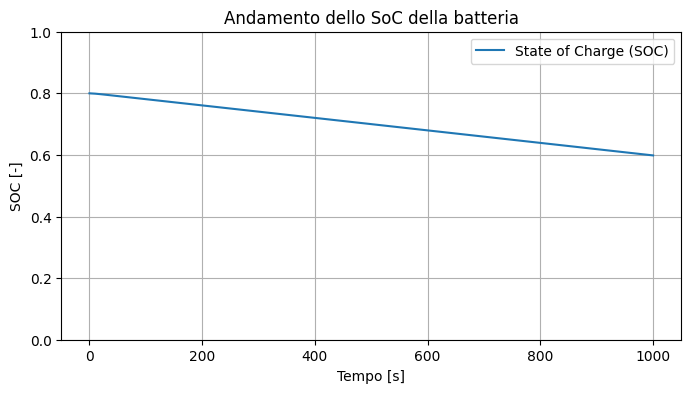

In [37]:
# --- Estrazione e grafico dello SoC ---
SOC = result.z_hist[:, 0]   # primo (e unico) stato della batteria
t = result.t

plt.figure(figsize=(8,4))
plt.plot(t, SOC, label="State of Charge (SOC)")
plt.xlabel("Tempo [s]")
plt.ylabel("SOC [-]")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.title("Andamento dello SoC della batteria")
plt.show()

plt.show()


In [ ]:
delta_soc = result.z_hist[:, 0][0] - result.z_hist[:, 0][-1]
print(delta_soc)




0.20160863583245092


In [38]:
Batt_i

array([  0.        , -13.62275856, -13.81929912, ..., -31.9228171 ,
       -31.91020127, -43.93649939], shape=(100001,))

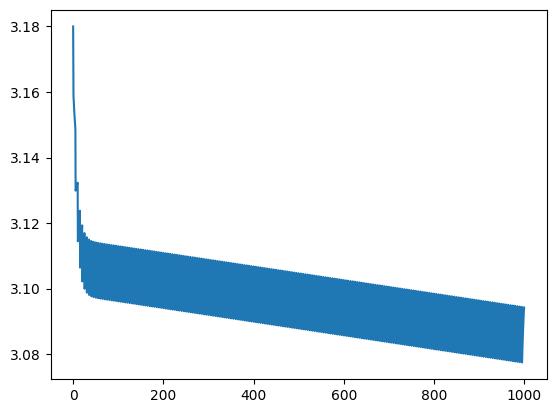

In [39]:
plt.plot(result.t, result.v_nodes[1])
plt.show()